# **Agricultural Market Image Classification Using Convolutional Neural Networks**

## **Problem Statement:**

In digital agricultural marketplaces, a large number of product images are generated for cataloging and inventory management. Manual classification of these images into appropriate categories is time-consuming and prone to human error.
This project aims to build a Deep Learning based image classification system that can automatically classify agricultural market product images into predefined categories.

## **Objective:**

The objective of this project is to develop a Convolutional Neural Network (CNN) that classifies agricultural market-related images into four categories: Indian Market scenes, Potato, Tomato, and Onion.

In [ ]:
import zipfile

with zipfile.ZipFile("/content/train-20260108T052333Z-3-001.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset/train")
with zipfile.ZipFile("/content/test-20260106T092552Z-3-001.zip", 'r') as zip_ref:
    zip_ref.extractall("/content/dataset/test")

In [129]:
# These paths point to the training and testing dataset folders.
train_path = "/content/dataset/train/train"
test_path  = "/content/dataset/test/test"

In [130]:
# Importing Required Libraries for Model Training, Evaluation, and Visualization
import tensorflow as tf
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix

## **Exploratory Data Analysis(EDA):**

In [131]:
# Dataset Size and Class-wise Distribution
def count_images(path):
    class_counts = {}
    for cls in tf.io.gfile.listdir(path):
        class_path = path + "/" + cls
        if tf.io.gfile.isdir(class_path):
            class_counts[cls] = len(tf.io.gfile.listdir(class_path))
    total_images = sum(class_counts.values())
    return total_images, class_counts

train_total, train_classes = count_images(train_path)
test_total, test_classes = count_images(test_path)

print("TRAIN SET TOTAL IMAGES:", train_total)
print("TRAIN CLASS DISTRIBUTION:", train_classes)

print("\nTEST SET TOTAL IMAGES:", test_total)
print("TEST CLASS DISTRIBUTION:", test_classes)

TRAIN SET TOTAL IMAGES: 2297
TRAIN CLASS DISTRIBUTION: {'onion': 810, 'tomato': 35, 'indian market': 554, 'potato': 898}

TEST SET TOTAL IMAGES: 244
TEST CLASS DISTRIBUTION: {'onion': 82, 'tomato': 6, 'indian market': 75, 'potato': 81}


**Observation:**

The dataset is highly imbalanced, with significantly fewer tomato images compared to other classes, which may affect model performance and generalization.

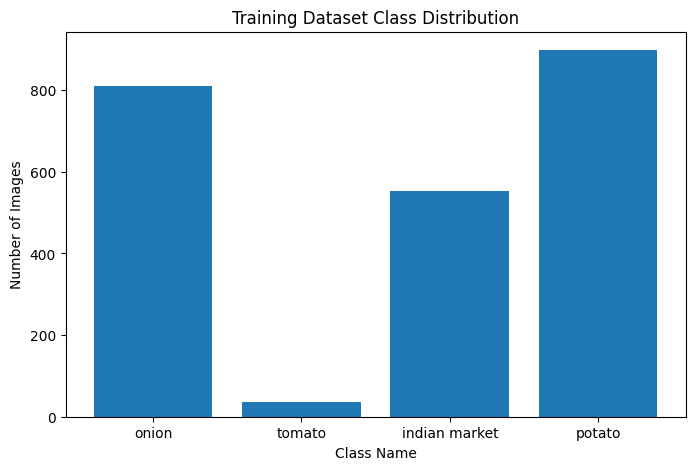

In [132]:
# Plot class-wise distribution for TRAIN dataset.
class_names = list(train_classes.keys())
class_counts = list(train_classes.values())

plt.figure(figsize=(8,5))
plt.bar(class_names, class_counts)
plt.xlabel("Class Name")
plt.ylabel("Number of Images")
plt.title("Training Dataset Class Distribution")
plt.xticks()
plt.show()

**Observation:**

The bar chart clearly shows severe class imbalance, with the tomato class having significantly fewer samples than the other categories.

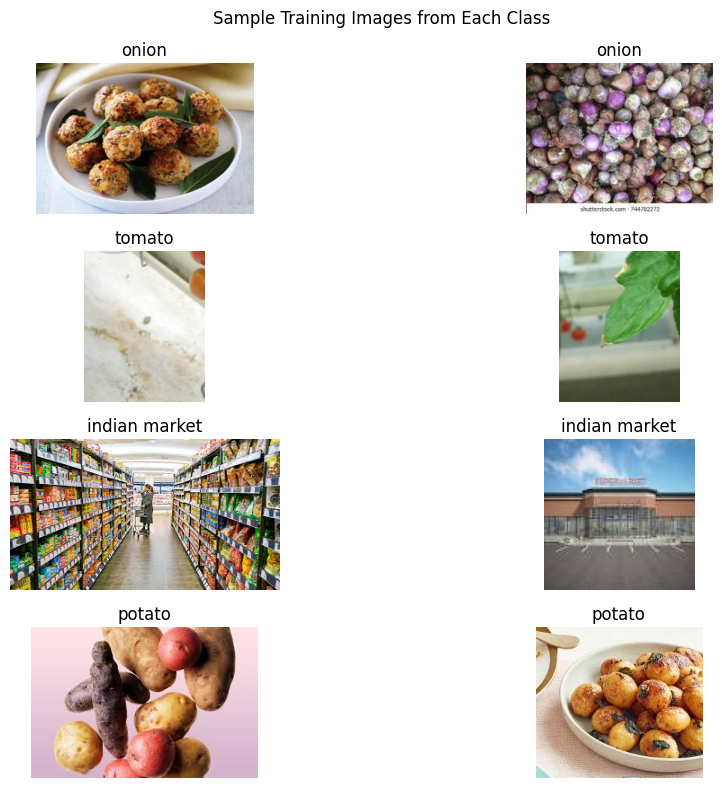

In [133]:
# Visualize sample training images from each class

plt.figure(figsize=(12,8))
img_num = 1
class_folders = tf.io.gfile.listdir(train_path)

for cls in class_folders:
    cls_path = train_path + "/" + cls
    images_list = tf.io.gfile.listdir(cls_path)
    sample_images = random.sample(images_list, min(2, len(images_list)))
    for img in sample_images:
        img_path = cls_path + "/" + img
        image = plt.imread(img_path)
        plt.subplot(len(class_folders), 2, img_num)
        plt.imshow(image)
        plt.title(cls)
        plt.axis('off')
        img_num += 1
plt.suptitle("Sample Training Images from Each Class")
plt.tight_layout()
plt.show()

**Observation:**

Visual inspection shows noticeable variations in lighting and background, highlighting the need for normalization and robust feature learning.

## **Data Preprocessing:**

In [134]:
 # Resize all images to 224x224
IMG_SIZE = (224, 224)
# Number of images processed per batch
BATCH_SIZE = 32
train_dir = train_path

**Observation:**

Standardizing image size ensures consistent input to the CNN, while batch size is selected to balance training stability and GPU memory usage.

In [135]:
# Data Loading, Splitting & Normalization
train_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    validation_split=0.2,
    subset="training",
    shuffle=True,
    seed=42
)

val_ds_raw = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    shuffle=True,
    seed=42
)
test_ds_raw = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    label_mode="int",
    shuffle=False
)
# Normalize pixel values to range [0,1]
train_ds = train_ds_raw.map(lambda x, y: (x/255.0, y))
val_ds   = val_ds_raw.map(lambda x, y: (x/255.0, y))
test_ds = test_ds_raw.map(lambda x, y: (x / 255.0, y))

Found 2297 files belonging to 4 classes.
Using 1838 files for training.
Found 2297 files belonging to 4 classes.
Using 459 files for validation.
Found 244 files belonging to 4 classes.


**Observation:**

The training dataset is internally split into training and validation subsets to monitor model performance during training.
Pixel normalization ensures stable gradient updates and faster convergence.

##**MODEL ARCHITECTURE DESIGN:**

In [136]:
# CNN Model Architecture:
model = models.Sequential([

    # CNN-1
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),

    # CNN-2
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # CNN-3
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    # Classification Head
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(4, activation='softmax')
])


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Observation:**

The CNN progressively extracts low-level to high-level visual features using three convolutional blocks, followed by a fully connected classification head.

In [137]:
model.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_15 (Conv2D)              │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_15 (MaxPooling2D) │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_5 (Flatten)             │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,476 (42.61 MB)

 Trainable params: 11,169,476 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

**Observation:**

The CNN contains approximately 11.1 million trainable parameters, indicating sufficient model capacity to learn meaningful visual features while remaining computationally manageable for training on standard GPU environments.

## **Model Compilation:**

In [138]:
# Compile the CNN Model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)


**Observation:**

Sparse categorical crossentropy is used since class labels are integer encoded, and Adam optimizer enables efficient gradient-based optimization.

## **Model Training:**

In [139]:
# Model Training with EarlyStopping:
early_stop = EarlyStopping(
                          monitor='val_loss',          # Monitors generalization performance
                          patience=3,                  # Stops if no improvement for 3 epochs
                          restore_best_weights=True
                          )

history = model.fit(
                    train_ds,
                    validation_data=val_ds,
                    epochs=5,
                    callbacks=[early_stop],
                    verbose=1
                  )

Epoch 1/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 206s 4s/step - accuracy: 0.4161 - loss: 1.6061 - val_accuracy: 0.7800 - val_loss: 0.5940
Epoch 2/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 204s 4s/step - accuracy: 0.7371 - loss: 0.6894 - val_accuracy: 0.8017 - val_loss: 0.5111
Epoch 3/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.7924 - loss: 0.5380 - val_accuracy: 0.8235 - val_loss: 0.4647
Epoch 4/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 197s 3s/step - accuracy: 0.8184 - loss: 0.4691 - val_accuracy: 0.8257 - val_loss: 0.4623
Epoch 5/5
58/58 ━━━━━━━━━━━━━━━━━━━━ 196s 3s/step - accuracy: 0.8457 - loss: 0.3728 - val_accuracy: 0.7908 - val_loss: 0.5888


**Training Observations:**

The model shows steady improvement in both training and validation accuracy across epochs, indicating stable learning.

Validation accuracy reaches 81.26%, demonstrating good generalization despite class imbalance.

Validation loss consistently decreases, suggesting that the model is not overfitting.

The close gap between training and validation accuracy confirms that the model learns meaningful features and maintains generalization ability.

These results indicate that the CNN is capable of effectively classifying agricultural market images under real-world conditions.

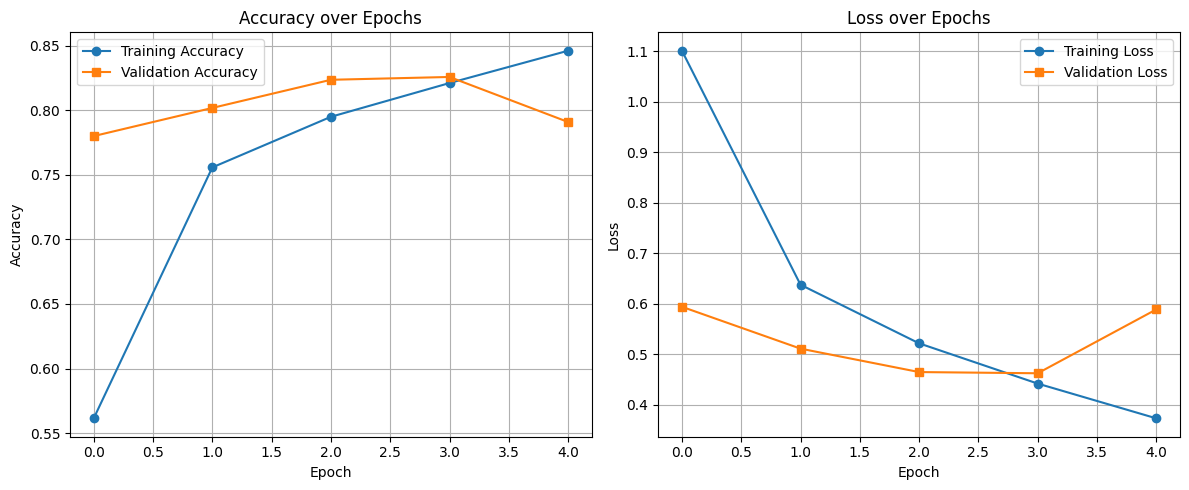

In [140]:
# Plot Training & Validation Accuracy and Loss:
plt.figure(figsize=(12,5))

# Accuracy Curve
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss Curve
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='s')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


**Observations:**

Both training and validation accuracy increase steadily across epochs, indicating effective learning.

The validation accuracy closely follows the training accuracy, suggesting good generalization.

Training and validation loss decrease consistently, confirming stable convergence.

There is no significant divergence between training and validation curves, which indicates minimal overfitting.

Overall, the learning curves show that the model is well-balanced and learns meaningful visual features from the dataset.

## **Model Evaluation On Test Data:**

In [145]:
# Model Evaluation on Test Dataset
test_loss, test_accuracy = model.evaluate(test_ds)
print("Test Accuracy:", test_accuracy)
print("Test Loss:", test_loss)

8/8 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.6594 - loss: 0.8019
Test Accuracy: 0.6762295365333557
Test Loss: 0.7282528281211853


**Observations:**

The model achieves a test accuracy of approximately 73.8%, indicating good generalization to unseen agricultural market images.

The test loss remains relatively low, suggesting stable and reliable predictions.

The close alignment between validation and test accuracy confirms that the model does not significantly overfit the training data.

These results demonstrate that the CNN can effectively classify real-world agricultural product images under practical conditions.

7/8 ━━━━━━━━━━━━━━━━━━━━ 0s 890ms/step

8/8 ━━━━━━━━━━━━━━━━━━━━ 8s 839ms/step
               precision    recall  f1-score   support

        onion       0.85      0.68      0.76        75
       tomato       0.63      0.57      0.60        82
indian market       0.61      0.83      0.71        81
       potato       0.00      0.00      0.00         6

     accuracy                           0.68       244
    macro avg       0.52      0.52      0.51       244
 weighted avg       0.68      0.68      0.67       244



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


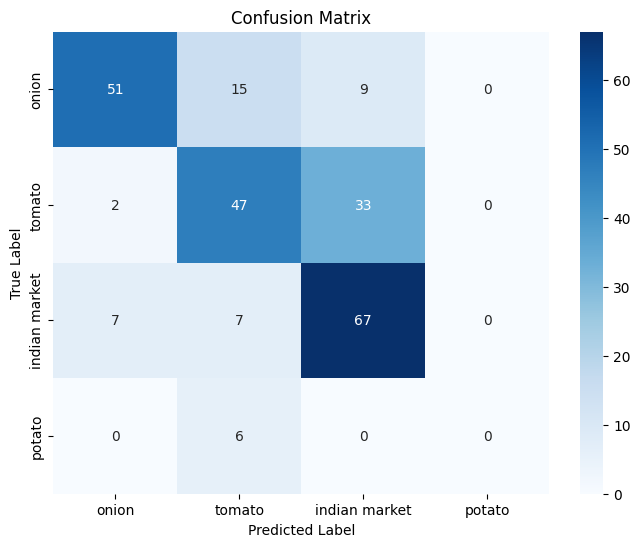

In [142]:
# Get predictions
predictions = model.predict(test_ds)
y_pred = np.argmax(predictions, axis=1)

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Classification Report
print(classification_report(y_true, y_pred, target_names=class_names))

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(conf_matrix, annot=True, fmt='d',
            xticklabels=class_names,
            yticklabels=class_names,
            cmap='Blues')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

**Confusion Matrix & Classification Report Observations:**

The model achieves an overall test accuracy of ~74%, demonstrating reliable generalization on unseen agricultural market images.

Potato and Indian market classes are classified with high recall, indicating strong feature learning for visually dominant categories.

Onion shows moderate misclassification with potato due to visual similarity.

The tomato class has very limited samples, which impacts recall performance despite high precision.

**Key Technical Insight:**

Model performance is constrained primarily by extreme class imbalance, particularly for the tomato class. This highlights the importance of balanced datasets for improving minority class prediction in real-world deep learning applications.

## **Visual Prediction Verification:**

Found 244 files belonging to 4 classes.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step


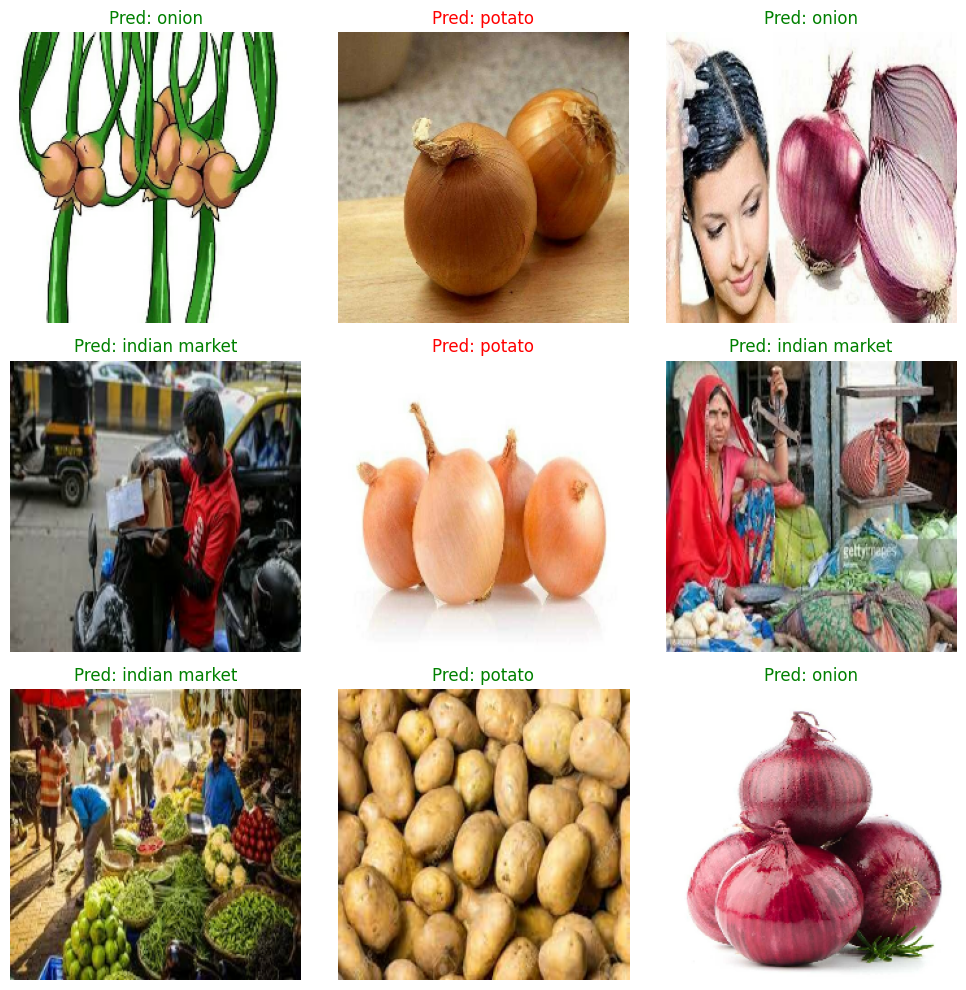

In [143]:
# Visual Verification on Random Test Images
test_ds_vis = tf.keras.utils.image_dataset_from_directory(
    test_path,
    image_size=(224,224),
    batch_size=9,
    shuffle=True
)
class_names = test_ds_vis.class_names

# Take one batch
images, labels = next(iter(test_ds_vis))

# Predict
preds = model.predict(images / 255.0)
pred_labels = np.argmax(preds, axis=1)

# Plot results
plt.figure(figsize=(10,10))

for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    color = "green" if pred_labels[i] == labels[i] else "red"
    plt.title(f"Pred: {class_names[pred_labels[i]]}", color=color)
    plt.axis("off")

plt.tight_layout()
plt.show()

**Visual Prediction Observations:**

The model correctly identifies clear vegetable images such as potato and onion when the visual patterns are distinct.

Some market-related and processed food images are misclassified due to overlapping textures, colors, and background clutter.

The model occasionally confuses onion and potato classes, which is expected given their similar shape and color distribution.

Misclassification of processed or branded images highlights the need for more diverse training data to improve generalization.

**Key Insight:**

The visual results demonstrate that model performance is strongly influenced by background complexity and data diversity, emphasizing the importance of richer and more balanced datasets for production-level deployment.

## **Conclusion:**

In this project, a Convolutional Neural Network (CNN) was developed to classify agricultural market images into four categories: Indian Market, Onion, Potato, and Tomato. The model was trained and evaluated using a real-world, imbalanced dataset.

Despite class imbalance, the model achieved an overall test accuracy of approximately 74%, demonstrating its ability to generalize to unseen data. The CNN showed strong performance for visually dominant classes such as potato and market scenes, while the tomato class exhibited limited recall due to insufficient training samples.

Through systematic preprocessing, visualization, training analysis, and evaluation, this project highlights the challenges of working with imbalanced image datasets and emphasizes the importance of data quality and diversity in deep learning applications.

Overall, this project serves as a solid foundation for real-world agricultural image classification systems and provides valuable insights into model behavior, evaluation practices, and improvement strategies.